In [39]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from random import randint
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.proportion import proportions_ztest
from ssrm_test import ssrm_test

# Исходные данные

**Описание исходных данных и схемы таблиц:**

1. **паспорт пользователя** (user_passports)
* **execution_date** - дата, на которую актуальны данные о зарегистрированных пользователях
* **created_at** - дата регистрации аккаунта пользователя
* **global_id** - ID пользователя в продукте
* **user_type_cars_name** - тип кабинета пользователя
<br>(a) cars_simple - простой кабинет,
<br>(b) cars_seller - кабинет продавца,
<br>(c) cars_dealer - кабинет дилера</br>
* **user_type_cars_id** - id типа кабинета пользователя
<br>(a) 0 - простой кабинет,
<br>(b) 6 - кабинет продавца,
<br>(c) 7 - кабинет дилера</br>


2. **размещенные объявления** (dp_live_adverts) - таблица с оптимизированными данными live_adverts
* **execution_date** - дата, на которую объявление находилось в live
* **advert_id** - уникальный номер объявления
* **created_at** - дата, когда было создано объявление
* **price** - стоимость авто в объявлении
* **region** - город, в котором продается авто
* **user_id** - ID пользователя в продукте (global_id в паспорте пользователя)
* **passport_id** - локальный ID пользователя
* **platform** - платформа, через которую было размещено объявление
<br>(a) android - мобильное приложение - android,
<br>(b) ios - мобильное приложение - ios,
<br>(c) desktop - подано через сайт,
<br>(d) mobile - подано в мобильной версии сайта,</br>
* **auto_brand** - марка авто
* **auto_model** - модель авто
* **year** - год выпуска авто
* **userType** - тип кабинета пользователя на момент размещения объявления в live

3. **транзакции** (user_transaction)
* **payment_date** - дата платежа
* **type** - вид оплачиваемой услуги
* **sign** - "-1" уазывает, что была приобретена услуга и списана оплата
* **amount** - количество списанных денег


# Загрузка данных по пользователям

In [3]:
df_user_passports = pd.read_csv('samples1.csv', encoding = 'utf-8')
df_user_passports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136584 entries, 0 to 136583
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   passport_id          136584 non-null  int64 
 1   region               133114 non-null  object
 2   platform             133114 non-null  object
 3   user_type_cars_name  130112 non-null  object
 4   number_ads           136584 non-null  int64 
 5   revenue              136584 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 6.3+ MB


In [5]:
df_user_passports = df_user_passports.dropna()

In [7]:
# Добавим столбец 'vas', где будет указано, платящий пользователь или нет
df_user_passports['vas'] = df_user_passports['revenue'].apply(lambda x: 'paying' if x > 0 else 'non-paying')

In [9]:
df_user_passports.head(5)

,passport_id,region,platform,user_type_cars_name,number_ads,revenue,vas
0,144161634,Санкт-Петербург,android,cars_seller,2,1080,paying
1,132683716,Калининград,android,cars_simple,1,190,paying
2,142653188,Санкт-Петербург,android,cars_seller,1,0,non-paying
3,124199631,Казань,android,cars_simple,1,190,paying
4,144045240,Казань,android,cars_simple,1,0,non-paying


# Платящие пользователи

In [17]:
# Найдём долю платящих пользователей
total_users = len(df_user_passports)
paying_users = (df_user_passports['vas'] == 'paying').sum()
share_of_paying_users = paying_users / total_users
print(f'Средняя доля платящих пользователей: {share_of_paying_users:.4}')

Средняя доля платящих пользователей: 0.5226


In [19]:
np.random.seed(42)
stratified_sample = (
    df_user_passports
    .groupby(['region', 'platform', 'user_type_cars_name', 'vas'], group_keys=False)
    .apply(lambda x: x.sample(frac=0.05, random_state=42))
)
print(f"Размер стратифицированной выборки: {len(stratified_sample)} строк")

Размер стратифицированной выборки: 6478 строк


C:\Users\ludwi\AppData\Local\Temp\ipykernel_11676\1778654473.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.05, random_state=42))


In [21]:
mean_paying = (stratified_sample['vas'] == 'paying').mean()

print(f"Средняя доля платящих пользователей: {mean_paying:.4f}")

Средняя доля платящих пользователей: 0.5221


In [23]:
mean_paying = (stratified_sample['platform'] == 'android').mean()

print(f"Доля android пользователей: {mean_paying:.4f}")

Доля android пользователей: 0.6425


# Проверка выборки на репрезентативность

- по параметру неплатящих пользователей (выборка['vas'] = 0);

- по платформе Андроид (выборка['platform'] = 'android');

- по типу профессионального кабинета cars_seller (выборка['user_type_cars_name'] = 'cars_seller').

In [27]:
# Функция для расчета p-value по z-тесту
def calc_p_value(full, sample, condition):
    count_full = condition(full).sum()
    count_sample = condition(sample).sum()
    n_full = len(full)
    n_sample = len(sample)
    
    count = np.array([count_sample, count_full])
    nobs = np.array([n_sample, n_full])
    
    stat, pval = proportions_ztest(count, nobs)
    return round(pval, 3)

In [29]:
# расчет p-value
pval_vas = calc_p_value(df_user_passports, stratified_sample, lambda df: df['vas'] == 'non-paying')

pval_android = calc_p_value(df_user_passports, stratified_sample, lambda df: df['platform'] == 'android')

pval_cars_seller = calc_p_value(df_user_passports, stratified_sample, lambda df: df['user_type_cars_name'] == 'cars_seller')

print(f"p-value по vas == 'non-paying': {pval_vas}")
print(f"p-value по platform == 'android': {pval_android}")
print(f"p-value по user_type_cars_name == 'cars_seller': {pval_cars_seller}")

p-value по vas == 'non-paying': 0.928
p-value по platform == 'android': 0.836
p-value по user_type_cars_name == 'cars_seller': 0.843


# Выгрузка данных по группам

In [31]:
dp_live_adverts = pd.read_csv('samples2.csv')
dp_live_adverts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26018 entries, 0 to 26017
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           26018 non-null  int64  
 1   passport_id          26018 non-null  int64  
 2   region               26018 non-null  object 
 3   platform             26018 non-null  object 
 4   user_type_cars_name  26018 non-null  object 
 5   number_ads           26018 non-null  int64  
 6   revenue              26018 non-null  int64  
 7   vas                  26018 non-null  int64  
 8   combined             26018 non-null  object 
 9   combined_weight      26018 non-null  float64
 10  group                26018 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 2.2+ MB


In [34]:
dp_live_adverts.dropna()
dp_live_adverts.head(5)

,Unnamed: 0,passport_id,region,platform,user_type_cars_name,number_ads,revenue,vas,combined,combined_weight,group
0,105602,136957831,Волгоград,android,cars_seller,1,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['A']
1,46619,142530464,Волгоград,android,cars_seller,1,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['B']
2,97503,143220356,Волгоград,android,cars_seller,2,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['B']
3,35633,137497307,Волгоград,android,cars_seller,1,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['A']
4,52222,131622431,Волгоград,android,cars_seller,1,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['A']


# Проверка на SRM

In [36]:
a = dp_live_adverts[dp_live_adverts['group'] == "['A']"]['passport_id'].count()
b = dp_live_adverts[dp_live_adverts['group'] == "['B']"]['passport_id'].count()
observed = [a, b]
total = a + b
ratio = 50
alpha = 0.05

expected = [ (total * ratio)/100, (total * (100 - ratio)/100) ] # ожидаемые размеры групп если бы ratio выполнялось полностью
print('Real sample sizes:', observed)
print('Expected sample sizes:', expected)

chi = ss.chisquare(observed, f_exp = expected) # считаем результаты точечной оценки доли через хи-квадрат критерий

if chi[1] < alpha:
    print('SRM, присутствует!!!')
else:
    print('SRM отсутствует')
print(chi)

Real sample sizes: [11748, 14270]
Expected sample sizes: [13009.0, 13009.0]
SRM, присутствует!!!
Power_divergenceResult(statistic=244.46475516949803, pvalue=4.180479887875548e-55)


# SSRM

In [48]:
np.random.seed(1)

# Ожидаемое разделение трафика между группами
expected = [ (total_traffic * ratio)/100, (total_traffic * (100 - ratio)/100) ]
print('Ожидаемое разделение:', expected)

# Реальное распределение трафика между группами
observed = [dp_live_adverts['group'].value_counts()[0], dp_live_adverts['group'].value_counts()[1]]
print('Наблюдаемое разделение:', observed)


# Заданное число пользователей
total_traffic = sum(observed)
print('Общий трафик:', total_traffic)

print(
    "Распределение трафика между группами, полученное в ходе эксперимента: {}% и {}%".format(
        round(100 * observed[0] / total_traffic, 1), round(100 * (total_traffic - observed[0]) / total_traffic, 1)
    )
)

Ожидаемое разделение: [13009.0, 13009.0]
Наблюдаемое разделение: [14270, 11748]
Общий трафик: 26018
Распределение трафика между группами, полученное в ходе эксперимента: 54.8% и 45.2%


C:\Users\ludwi\AppData\Local\Temp\ipykernel_11676\3701204479.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  observed = [dp_live_adverts['group'].value_counts()[0], dp_live_adverts['group'].value_counts()[1]]
C:\Users\ludwi\AppData\Local\Temp\ipykernel_11676\3701204479.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  observed = [dp_live_adverts['group'].value_counts()[0], dp_live_adverts['group'].value_counts()[1]]


In [53]:
# Ожидаемое разделение трафика между группами
expected_pct = [0.5, 0.5]

# Реальное распределение трафика между группами
observed = [dp_live_adverts['group'].value_counts()[0], dp_live_adverts['group'].value_counts()[1]]

# Распределение трафика между группами, полученное в ходе эксперимента
observed_pct = [round(observed[0] / total_traffic, 2), round((total_traffic - observed[0]) / total_traffic, 2)]
print('Всего пользователей:', observed_pct)

Всего пользователей: [0.55, 0.45]


C:\Users\ludwi\AppData\Local\Temp\ipykernel_11676\1958701625.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  observed = [dp_live_adverts['group'].value_counts()[0], dp_live_adverts['group'].value_counts()[1]]
C:\Users\ludwi\AppData\Local\Temp\ipykernel_11676\1958701625.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  observed = [dp_live_adverts['group'].value_counts()[0], dp_live_adverts['group'].value_counts()[1]]


In [57]:
# преобразуем группы А и Б в формат, требуемый SSRM
def map_value(value):
    if value == "['A']":
        return [1, 0]
    elif value == "['B']":
        return [0, 1]
    else:
        return None

# преобразуем данные в список
dp_live_adverts['data'] = dp_live_adverts['group'].apply(map_value)
data = dp_live_adverts['data'].to_list()

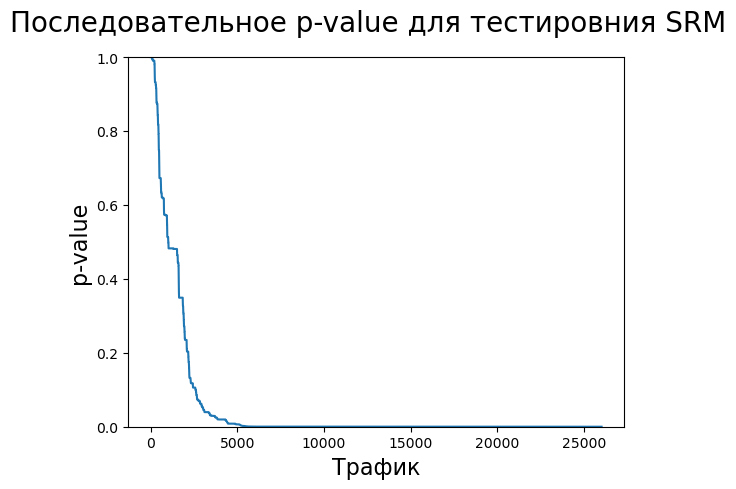

In [61]:
pvals = ssrm_test.sequential_p_values(data, expected_pct)
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Последовательное p-value для тестировния SRM", fontsize=20)
plt.xlabel("Трафик", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

In [63]:
sig_reached = np.argmax(np.array(pvals) < 0.05)

print(
    "SSRM отклонило нулевую гипотезу об отсутствии SRM при уровне значимости alpha=0.05 после {} пользователей".format(
        sig_reached)
)
print(
    "Это {}% от общего числа пользователей для этого эксперимента".format(
        round(100 * sig_reached / total_traffic), 3)
)

SSRM отклонило нулевую гипотезу об отсутствии SRM при уровне значимости alpha=0.05 после 3023 пользователей
Это 12% от общего числа пользователей для этого эксперимента
